# Import and Ingest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

## Cutoff until 2017

In [2]:
df = pd.read_csv('data.csv')
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'].dt.year <= 2017]
df.set_index('date', inplace = True)
print(df.shape)  # (123, 8)
df.tail()

(1096, 12)


,Bitcoin,Bitcoin Crash,Blockchain,Crisis,Cryptocurrency,Nicehash,Hashing,GPU,GeForce,mining,Tesla,Price
date,,,,,,,,,,,,
2017-12-27,32.0,6.0,59.0,28.80,23.22,18.0,59.0,71.78,39.60,73.0,31.68,16930.900391
2017-12-28,33.0,4.0,59.0,29.44,25.37,22.0,52.0,69.56,31.35,72.0,28.16,15888.400391
2017-12-29,27.0,7.0,48.0,32.64,26.66,17.0,48.0,65.12,37.40,61.0,25.28,15279.000000
2017-12-30,27.0,10.0,42.0,28.80,29.67,22.0,44.0,62.90,37.95,64.0,24.32,14681.900391
2017-12-31,22.0,5.0,39.0,24.96,24.51,26.0,48.0,68.08,34.10,63.0,21.44,14377.400391


# Visualize the Time Series

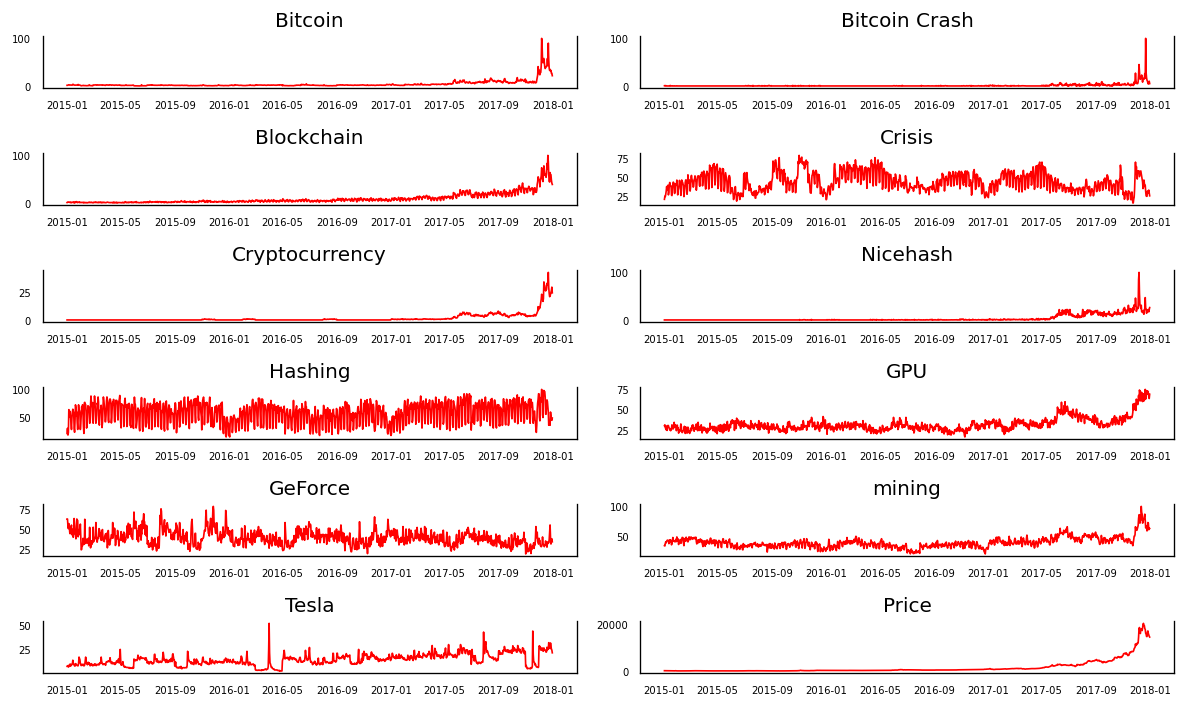

In [3]:
# Plot
fig, axes = plt.subplots(nrows=6, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# Testing Causation using Granger’s Causality Test

In [4]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)    

,Bitcoin_x,Bitcoin Crash_x,Blockchain_x,Crisis_x,Cryptocurrency_x,Nicehash_x,Hashing_x,GPU_x,GeForce_x,mining_x,Tesla_x,Price_x
Bitcoin_y,1.0000,0.0000,0.0000,0.0297,0.0000,0.0000,0.0060,0.0000,0.0737,0.0,0.0035,0.0000
Bitcoin Crash_y,0.0000,1.0000,0.0000,0.3860,0.0000,0.0000,0.0424,0.0000,0.0119,0.0,0.0000,0.0000
Blockchain_y,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0057,0.0,0.0012,0.0000
Crisis_y,0.0346,0.0468,0.0004,1.0000,0.0129,0.0252,0.0000,0.0012,0.0000,0.0,0.0000,0.0099
Cryptocurrency_y,0.0000,0.0000,0.0000,0.0232,1.0000,0.0000,0.0011,0.0000,0.4655,0.0,0.0455,0.0000
Nicehash_y,0.0000,0.0000,0.0000,0.0055,0.0000,1.0000,0.0610,0.0000,0.0510,0.0,0.0001,0.0000
Hashing_y,0.0002,0.0394,0.0000,0.0000,0.0001,0.0000,1.0000,0.0000,0.0003,0.0,0.0474,0.0000
GPU_y,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,1.0000,0.0010,0.0,0.0001,0.0000
GeForce_y,0.0104,0.0547,0.0000,0.0000,0.0121,0.0013,0.0000,0.0896,1.0000,0.0,0.0005,0.0002
mining_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0,0.0019,0.0000


# Cointegration Test

In [5]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name            ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col, 15), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name            ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Bitcoin         ::  934.02    > 311.1288  =>   True
Bitcoin Crash   ::  658.3     > 263.2603  =>   True
Blockchain      ::  405.4     > 219.4051  =>   True
Crisis          ::  309.29    > 179.5199  =>   True
Cryptocurrency  ::  225.5     > 143.6691  =>   True
Nicehash        ::  159.9     > 111.7797  =>   True
Hashing         ::  100.16    > 83.9383   =>   True
GPU             ::  64.87     > 60.0627   =>   True
GeForce         ::  40.29     > 40.1749   =>   True
mining          ::  18.55     > 24.2761   =>   False
Tesla           ::  3.32      > 12.3212   =>   False
Price           ::  1.32      > 4.1296    =>   False


# Split the Series into Training and Testing Data

In [6]:
nobs = 20
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(1076, 12)
(20, 12)


# Check for Stationarity and Make the Time Series Stationary

In [7]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
        return True
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 
        return False
# ADF Test on each column
stationary = True
for name, column in df_train.iteritems():
    temp = adfuller_test(column, name=column.name)
    stationary = stationary and temp
    print('\n')
if stationary:
    print('Proceed')
else:
    print('Need differencing')

    Augmented Dickey-Fuller Test on "Bitcoin" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.6739
 No. Lags Chosen       = 22
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.9981. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Bitcoin Crash" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 2.857
 No. Lags Chosen       = 20
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 1.0. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Blockchain" 
    -----------------------------------------------
 Null Hypothesis: Da

## 1st difference

In [8]:
df_differenced = df_train.diff().dropna()
# ADF Test on each column of 1st Differences Dataframe
stationary = True
for name, column in df_differenced.iteritems():
    temp = adfuller_test(column, name=column.name)
    stationary = stationary and temp
    print('\n')
if stationary:
    print('Proceed')
else:
    print('Need differencing')

    Augmented Dickey-Fuller Test on "Bitcoin" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.7368
 No. Lags Chosen       = 22
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.9905. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Bitcoin Crash" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.3273
 No. Lags Chosen       = 22
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0137. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Blockchain" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root.

## 2nd difference

In [9]:
df_differenced = df_differenced.diff().dropna()
# ADF Test on each column of 1st Differences Dataframe
stationary = True
for name, column in df_differenced.iteritems():
    temp = adfuller_test(column, name=column.name)
    stationary = stationary and temp
    print('\n')
if stationary:
    print('Proceed')
else:
    print('Need differencing')

    Augmented Dickey-Fuller Test on "Bitcoin" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.9304
 No. Lags Chosen       = 22
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Bitcoin Crash" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.7137
 No. Lags Chosen       = 22
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Blockchain" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signific

# Select the Order (P) of VAR model

In [10]:
model = VAR(df_differenced)
x = model.select_order(maxlags=20)
x.summary()

C:\Users\Public\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,44.19,44.25,1.561e+19,44.22
1,39.14,39.88,9.986e+16,39.42
2,36.22,37.63,5.361e+15,36.75
3,34.70,36.79,1.179e+15,35.50
4,33.71,36.48,4.363e+14,34.76
5,32.46,35.90,1.251e+14,33.76
6,30.68,34.80,2.118e+13,32.24
7,29.67,34.47*,7.713e+12,31.49
8,29.28,34.76,5.232e+12,31.36
9,29.02,35.17,4.040e+12,31.35*


# Train the VAR Model of Selected Order(p)

In [11]:
model_fitted = model.fit(20)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 27, Jun, 2022
Time:                     00:22:15
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                    40.8739
Nobs:                     1054.00    HQIC:                   32.4232
Log likelihood:          -29422.6    FPE:                7.64349e+11
AIC:                      27.2635    Det(Omega_mle):     6.45865e+10
--------------------------------------------------------------------
Results for equation Bitcoin
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.017744         0.033612            0.528           0.598
L1.Bitcoin                -1.304262         0.055441          -23.525           0.000
L1.Bitcoin Crash           0.088738   

# Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [12]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

Bitcoin : 1.97
Bitcoin Crash : 1.99
Blockchain : 2.07
Crisis : 1.99
Cryptocurrency : 1.98
Nicehash : 2.02
Hashing : 2.01
GPU : 2.02
GeForce : 2.01
mining : 2.01
Tesla : 2.01
Price : 1.95


# Forecast VAR model using statsmodels

In [13]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

20


array([[-3.28000000e+00, -3.51000000e+00, -1.65000000e+00,
        -8.40000000e+00, -1.56000000e+00,  2.30000000e+00,
        -1.65600000e+01,  2.28000000e+00, -9.54000000e+00,
        -1.32000000e+00, -1.32000000e+00, -5.82001953e+01],
       [ 1.23000000e+00,  1.89000000e+00, -9.35000000e+00,
        -2.10000000e+00,  7.20000000e-01, -8.74000000e+00,
         1.19600000e+01,  1.71000000e+00,  1.16600000e+01,
         0.00000000e+00,  3.08000000e+00,  1.15410156e+01],
       [ 1.23000000e+00, -2.70000000e-01,  1.10000000e+01,
         8.40000000e+00,  3.60000000e-01,  1.70200000e+01,
        -9.20000000e+00,  6.27000000e+00,  4.77000000e+00,
         7.26000000e+00, -2.64000000e+00,  1.41619141e+02],
       [-8.88178420e-16,  1.62000000e+00, -3.30000000e+00,
         4.90000000e+00,  1.20000000e+00, -1.74800000e+01,
         6.44000000e+00, -1.76700000e+01, -2.59700000e+01,
         6.60000000e-01,  8.80000000e-01,  3.10000000e+02],
       [ 4.92000000e+00,  5.13000000e+00,  6.0500000

In [14]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,Bitcoin_2d,Bitcoin Crash_2d,Blockchain_2d,Crisis_2d,Cryptocurrency_2d,Nicehash_2d,Hashing_2d,GPU_2d,GeForce_2d,mining_2d,Tesla_2d,Price_2d
date,,,,,,,,,,,,
2017-12-12,-24.628065,-19.390918,16.234661,22.581810,-3.927956,20.319724,-55.691485,12.385770,23.823826,1.877717,29.822968,-1948.606838
2017-12-13,14.832030,27.106469,-52.148415,-13.362501,6.766431,-8.679894,3.435185,45.228404,-22.568366,-5.791016,-36.199967,230.550444
2017-12-14,48.347730,16.909925,38.236152,-14.024989,0.852725,42.144502,73.130272,-53.930766,-11.510157,20.359755,-0.614051,2988.907627
2017-12-15,16.337842,9.718802,12.237643,33.255271,1.461940,-14.168242,-48.657467,-22.029552,-18.827657,11.793503,10.071860,1901.791828
2017-12-16,-72.334402,-55.660479,-56.762523,-53.048240,-12.379732,-60.925148,38.213620,15.141882,-1.029978,-44.330666,20.468680,-4992.915208
2017-12-17,-35.226676,-5.753727,-14.658867,-18.066130,4.060306,-67.528171,-137.651287,31.304812,88.049653,30.709180,-41.833433,-3620.897763
2017-12-18,19.163473,18.046998,39.959511,38.218961,-2.240754,84.093038,110.806891,-7.092828,-63.964437,-19.249024,9.307821,2177.975822
2017-12-19,51.232149,13.535052,57.660770,-1.972430,3.583214,62.321291,-32.881640,-14.415126,-11.184874,-2.864211,11.542069,5007.734899
2017-12-20,-27.324342,-24.359332,-33.923223,50.439668,-0.048876,-45.584907,12.536581,32.688431,81.905579,21.434895,36.300643,-2522.351543


# Invert the transformation to get the real forecast

In [15]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [16]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)
cols = [s + '_forecast' for s in df.columns.values.tolist()]
df_results.loc[:, cols]

,Bitcoin_forecast,Bitcoin Crash_forecast,Blockchain_forecast,Crisis_forecast,Cryptocurrency_forecast,Nicehash_forecast,Hashing_forecast,GPU_forecast,GeForce_forecast,mining_forecast,Tesla_forecast,Price_forecast
date,,,,,,,,,,,,
2017-12-12,40.371935,-1.390918,93.234661,84.021810,18.002044,40.319724,69.308515,60.485770,52.973826,77.877717,52.542968,17228.594334
2017-12-13,38.575901,8.324632,73.320907,96.441120,23.420520,47.959553,55.052216,106.259943,52.579286,72.964418,45.845970,17173.838722
2017-12-14,85.127596,34.950108,91.643305,94.835440,29.691721,97.743884,113.926189,98.103350,40.674590,88.410874,38.534920,20107.990736
2017-12-15,148.017134,71.294385,122.203346,126.485032,37.424861,133.359974,124.142694,67.917205,9.942237,115.650832,41.295731,24943.934578
2017-12-16,138.572270,51.978183,96.000864,105.086383,32.778270,108.050915,172.572820,52.872942,-21.820095,98.560125,64.525222,24786.963212
2017-12-17,93.900730,26.908254,55.139515,65.621604,32.191985,15.213685,83.351658,69.133491,34.467227,112.178596,45.921280,21009.094082
2017-12-18,68.392662,19.885323,54.237677,64.375786,29.364945,6.469493,104.937388,78.301212,26.790112,106.548044,36.625159,19409.200775
2017-12-19,94.116744,26.397444,110.996608,61.157539,30.121120,60.046592,93.641477,73.053808,7.928124,98.053281,38.871108,22817.042367
2017-12-20,92.516484,8.550232,133.832318,108.378958,30.828419,68.038783,94.882148,100.494835,70.971714,110.993412,77.417699,23702.532416


# Plot of Forecast vs Actuals

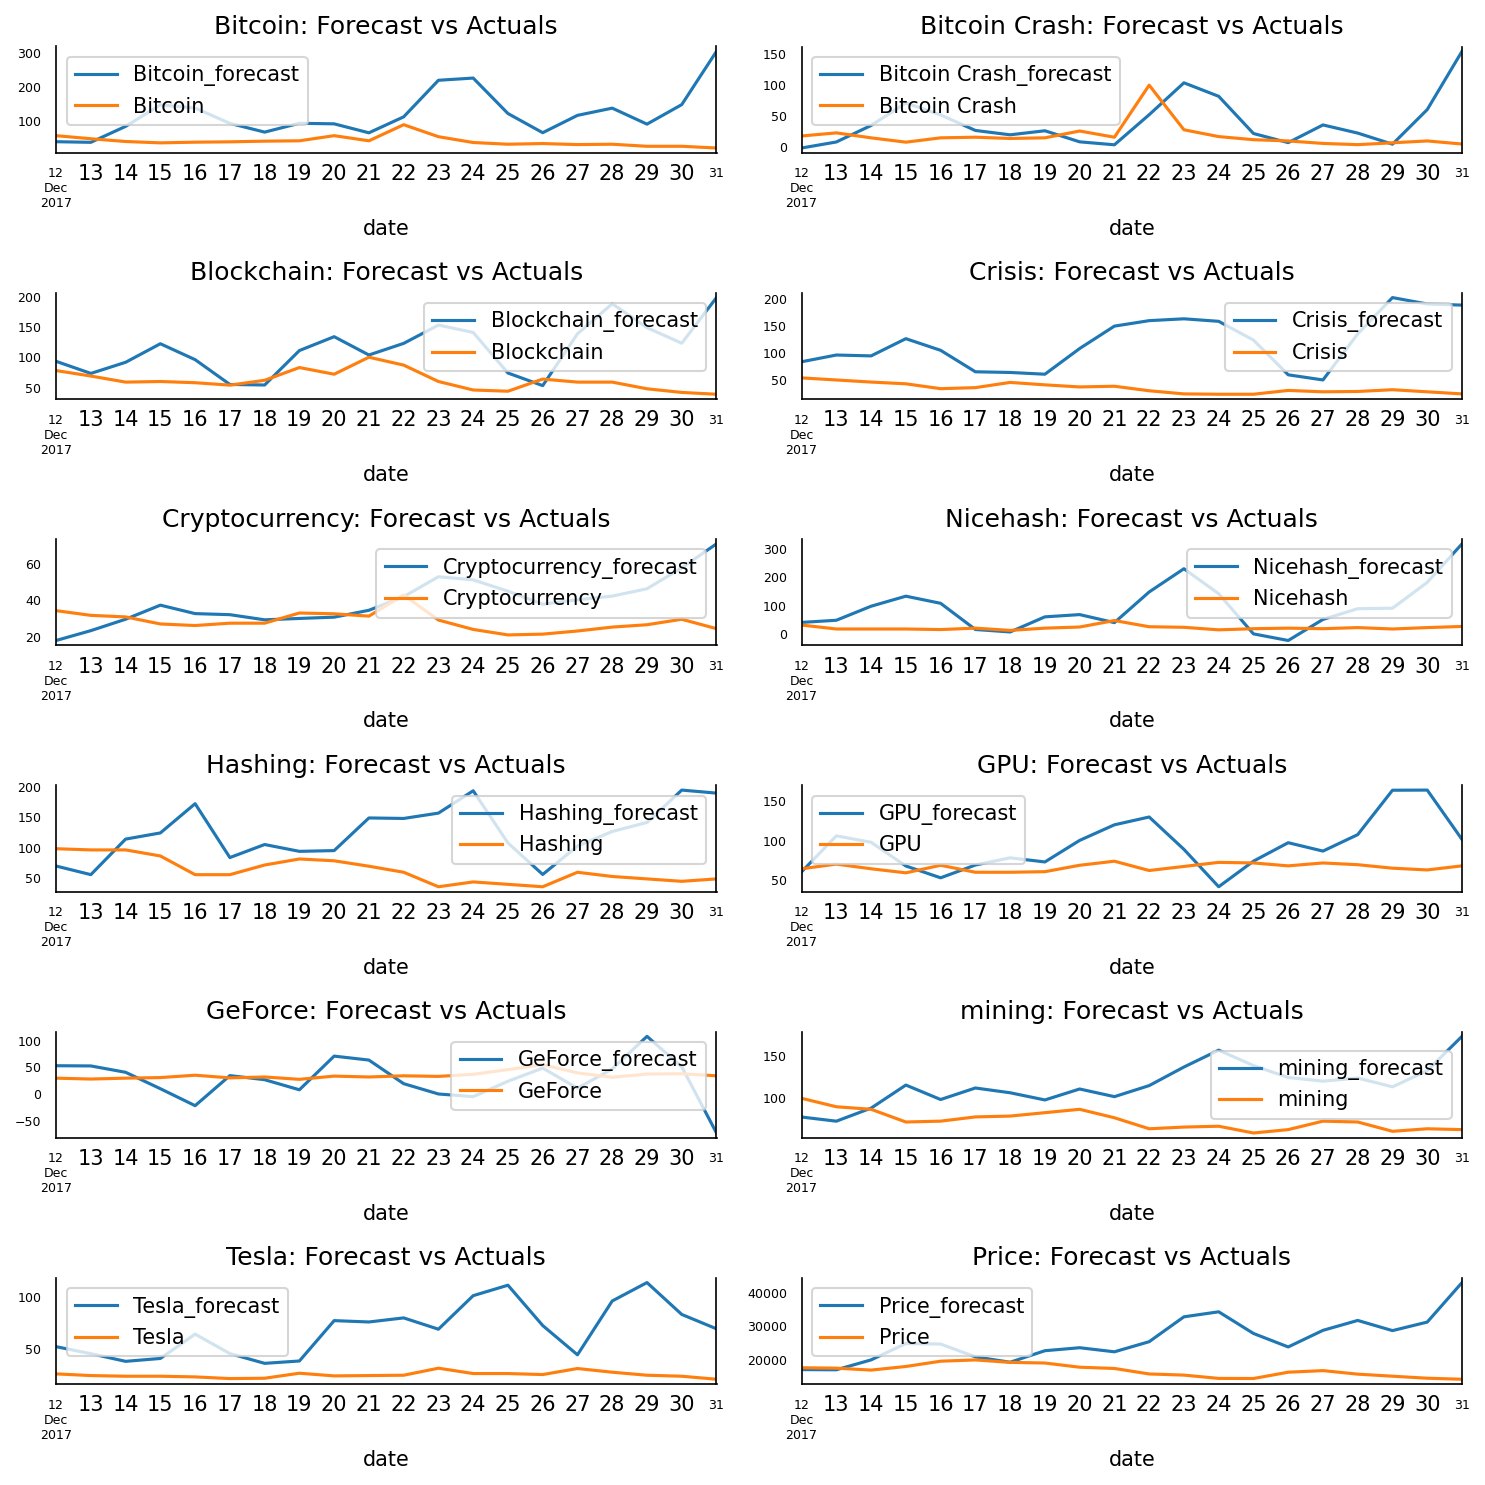

In [17]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# Evaluate the Forecasts

In [18]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [19]:
for col in df.columns.values.tolist():
    print('\nForecast Accuracy of: ' + col)
    accuracy_prod = forecast_accuracy(df_results[col + '_forecast'].values, df_test[col])
    for k, v in accuracy_prod.items():
        print(k, ': ', round(v,4))


Forecast Accuracy of: Bitcoin
mape :  2.4426
me :  78.6018
mae :  81.407
mpe :  2.3909
rmse :  105.2598
corr :  -0.2884
minmax :  0.5831

Forecast Accuracy of: Bitcoin Crash
mape :  3.4877
me :  21.5632
mae :  33.2092
mpe :  3.065
rmse :  47.75
corr :  0.0315
minmax :  0.6483

Forecast Accuracy of: Blockchain
mape :  1.0201
me :  51.584
mae :  53.44
mpe :  0.9907
rmse :  69.3897
corr :  -0.2308
minmax :  0.3963

Forecast Accuracy of: Crisis
mape :  2.7368
me :  83.819
mae :  83.819
mpe :  2.7368
rmse :  98.342
corr :  -0.4942
minmax :  0.6326

Forecast Accuracy of: Cryptocurrency
mape :  0.5388
me :  10.7561
mae :  13.9372
mpe :  0.4438
rmse :  18.2226
corr :  -0.3516
minmax :  0.3034

Forecast Accuracy of: Nicehash
mape :  3.9343
me :  71.0211
mae :  79.0057
mpe :  3.5278
rmse :  107.9043
corr :  0.0596
minmax :  0.773

Forecast Accuracy of: Hashing
mape :  1.3684
me :  61.563
mae :  68.5269
mpe :  1.2964
rmse :  82.7091
corr :  -0.4756
minmax :  0.4868

Forecast Accuracy of: GPU
map

C:\Users\silly bb\AppData\Local\Temp\ipykernel_26132\3132832150.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\silly bb\AppData\Local\Temp\ipykernel_26132\3132832150.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
